In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [12]:
!pip install kafka
!pip install boto3
!mkdir -p data/production
!mkdir -p data/model

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
import os
import ssl
import boto
import boto.s3.connection

predict_data_dir = "data/predict"
models_data_dir = "data/model"

access_key = 'quy8WT14myuVYD7yz8cn'
secret_key = 'DsqGdYWXr3uOQo0QjSqbCzK3ht3fjTWn57rVZflW'
s3_gateway = 's3.openshift-storage.svc'
s3_port = 443

# do not verify ssl certificate
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

conn = boto.connect_s3(
       aws_access_key_id = access_key,
       aws_secret_access_key = secret_key,
       host = s3_gateway,
       port = s3_port,
       calling_format = boto.s3.connection.OrdinaryCallingFormat(),
       )

def getDataFromS3(conn, bucket_name, directory, files):
    # bind to bucket
    bucket = conn.get_bucket(bucket_name, validate=False)

    for item in files:
        key = bucket.get_key(item)
        key.get_contents_to_filename(os.path.join(directory, item))
    return

# filenames
model_weights = 'well_trained_model.h5'
model_json = 'well_trained_model.json'

# download the model from ceph
getDataFromS3(conn, 'models', models_data_dir, [model_weights, model_json])

import json

from livelossplot import PlotLossesKeras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import model_from_json


# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 32
BATCH_SIZE = 8
DROPOUT = 0.5
LEARNING_RATE = 0.0001

class ConvNN:
    
    def __init__(self, image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT, epochs=32, batch_size=8, 
                 dropout=DROPOUT, learning_rate=LEARNING_RATE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), 
                 training_dir='', validation_dir='', test_dir='', 
                 model_filename='cnn', verbose=True):
        
        self.image_width = image_width
        self.image_height = image_height
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout = dropout
        self.lr = learning_rate
        self.input_shape = input_shape
        self.training_dir = training_dir
        self.validation_dir = validation_dir
        self.test_dir = test_dir
        self.model_filename = model_filename
        self.verbose = verbose
        self.accuracy = ''

    # create the convolutional neural network
    def create(self):
        self.model = Sequential()

        self.model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=self.input_shape, activation='relu'))
        self.model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
        self.model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
        self.model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
        self.model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Flatten())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dropout(self.dropout))

        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dropout(self.dropout))

        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))

        self.model.compile(loss='binary_crossentropy',
                            optimizer=RMSprop(lr=self.lr),
                            metrics=['accuracy'])
        
        with open(self.model_filename + '.txt', "w") as fh:
            self.model.summary(print_fn=lambda line: fh.write(line + "\n"))
                    
    def load(self, weights_filename):
        self.model.load_weights(weights_filename)
    
    # evaluate model
    def evaluate(self, test_size=1):
        test_file = self.model_filename + 'test.txt'
        test_data_generator = ImageDataGenerator(rescale=1./255)
        test_generator = test_data_generator.flow_from_directory(
                            self.test_dir,
                            target_size=(self.image_width, self.image_height),
                            batch_size=1,
                            class_mode="binary", 
                            shuffle=False)
        
        open(test_file, "w")
        probabilities = self.model.predict_generator(test_generator, test_size)
        for index, probability in enumerate(probabilities):
            image_path = os.path.join(self.test_dir, test_generator.filenames[index]) 
            img = mpimg.imread(image_path)
            with open(test_file, "a") as fh:
                fh.write(str(probability[0]) + " for: " + image_path + "\n")
            plt.imshow(img)
            if probability > 0.5:
                plt.title("%.2f" % (probability[0]*100) + "% dog.")
            else:
                plt.title("%.2f" % ((1-probability[0])*100) + "% cat.")
            plt.show()
                          
    def predict(self, images):       
        return self.model.predict_classes(images)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import numpy as np

from keras import backend as K
import ssl
import os

# you can install python modules if they are not available on the notebook
from kafka import KafkaConsumer, TopicPartition
from kafka.errors import KafkaError

# model creation
model = ConvNN()

# load weights
weights_filename = os.path.join('data/model', model_weights)

model.create()
model.load(weights_filename)

# you should change this value to fit your environment
kafkaendpoint = 'odh-message-bus-kafka-bootstrap-binary-classification.apps.cluster-syone-a5ce.syone-a5ce.example.opentlc.com:443'

def get_images_from_kafka(kafkaendpoint, topic, dest_dir):
    consumer = KafkaConsumer(bootstrap_servers=kafkaendpoint,
                             auto_offset_reset='earliest',
                             enable_auto_commit=False,
                             ssl_context= ssl._create_unverified_context(),
                             security_protocol='SSL',
                             heartbeat_interval_ms=1000,
                             group_id='consumer-group2')
    
    # assigning consumer to a kafka partition
    tp = TopicPartition(topic=topic, partition=0)
    consumer.assign([tp])
    consumer.seek_to_beginning(tp)  
    # lastOffset in topic
    lastOffset = consumer.end_offsets([tp])[tp]

    # read images
    count = 1
    for message in consumer:
        # stop reading when there is no more messages on topic
        if consumer.position(tp) == lastOffset:
            image_filename = os.path.join(dest_dir, str(count)+'.jpg')
            message = message.value
            fd = open(image_filename,'wb')
            fd.write(message)
            fd.close()
            break
            
        image_filename = os.path.join(dest_dir, str(count)+'.jpg')
        message = message.value
        fd = open(image_filename,'wb')
        fd.write(message)
        fd.close()
        count += 1
    
    consumer.close()
    
    return

# read images from kafka and store it to local disk
production_topic = 'predict'
production_data_dir = 'data/production'
get_images_from_kafka(kafkaendpoint, production_topic, production_data_dir)

# predict images
predict_images = [os.path.join(production_data_dir, f) for f in os.listdir(production_data_dir) 
                      if os.path.isfile(os.path.join(production_data_dir, f))]

def classify(data, model):
    dogs = []
    cats = []
    images = []
    # reshape the image to be used in the neural network
    for item in data:
        image = Image.open(item)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        images.append(np.array(image))

    images = np.array(images)
    if K.image_data_format() == 'channels_first':
        images = images.reshape(images.shape[0], 3, IMAGE_WIDTH, IMAGE_HEIGHT)
    else:
        images = images.reshape(images.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT, 3)
               
    return model.predict(images)

# predict the data from kafka
predictions = classify(predict_images, model)

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(200, 200,..., activation="relu", padding="same")`
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/opt/app-root/lib/python3.6/site-packages/ipykernel_laun

14/14 [==============================] - 4s 297ms/step


## Predicted Cats

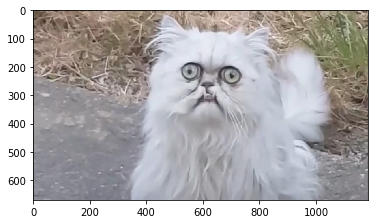

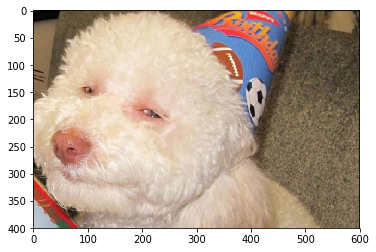

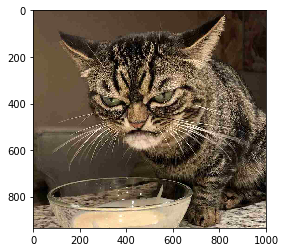

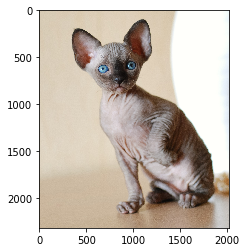

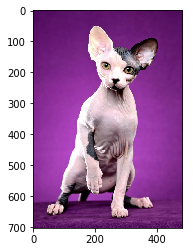

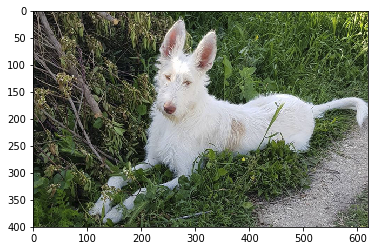

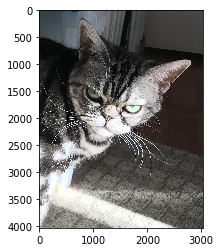

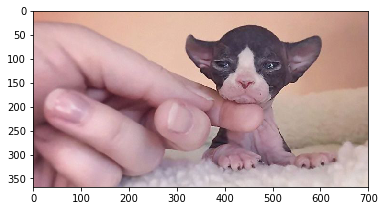

In [15]:
# 0 -> cat
# 1 -> dog
for item in range(0, len(predictions)):
    if predictions[item][0] == 0:
        plt.figure()
        img = mpimg.imread(predict_images[item])
        plt.imshow(img)

## Predicted Dogs

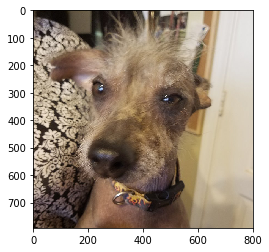

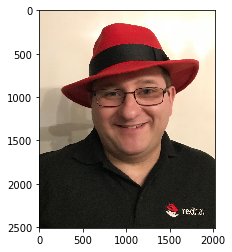

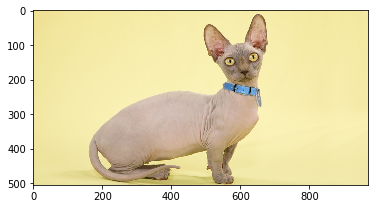

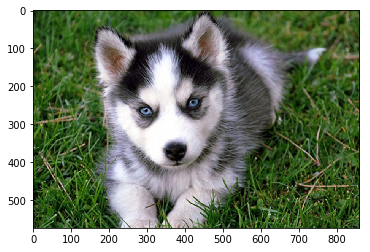

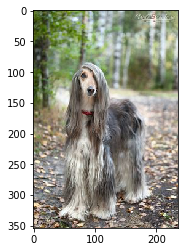

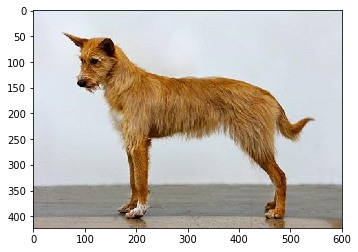

In [16]:
for item in range(0, len(predictions)):
    if predictions[item][0] == 1:
        plt.figure()
        img = mpimg.imread(predict_images[item])
        plt.imshow(img)